In [2]:
import numpy as np

import matplotlib.pyplot as plt

# Linear Advection

Hydrodynamics is a system of non-linear PDE's that involve advection of mass, momenum and energy. We will start with a simple advection equation:

$$ a_{t} + u a_{x} = 0 $$

This requires initial conditions, $a(x, t=0)$ and a boundary condition. The soltuin to this is easy to write down:

$$a(x, t) = a(x-ut) $$

Any intial profile $a(\xi)$ is simple advected to the right (for $u>0$) at a velcity $u$.

## Representing Data

The process of turning a continuous function, $a(x)$ into a finite number of values that can be stored on a computer is called a $\it{discretization}$.

We will divide our domain into a grid and store the function value at each point on the grid and use the notation $a^{n}_{i} = a(x_{i}, t^{n})$ to represent the discrete data in the space and time.

## First Attempt

We might try to build on to what we have already learned:

 * a centered difference for $a_x$ is second-order accurate, so that should be used for discretizing the space terms

 * we can doa simple explicit Euler method to update the solution in time

This would look like:

$$ \frac{a^{n+1}_{i} - a^{n}_{i}} {\Delta t} = -u \frac{a^{n}_{i+1} - a^{n}_{i-1}}{2 \Delta x}$$

This scheme is an explicit update (the right hand side only depends on the information from the old time which we know). As this is first order in time and second order in space, this method is called the FTCS (forward time centre space)

We can write this as:

$$a^{n+1}_{i} = a^{n}_{i} - \frac{C}{2} \left( a_{i+1}^{n} - a^{n}_{i-1} \right)$$

where we introduce the Courant number $C$:

$$ C = \frac{u \Delta t}{\Delta x}$$

which is also referred to as the Courant-Friedrichs-Lewy or CFL number. $C$ is dimensionless and is a measure of that fraction of a zone we cross per timestep.

Now imagine that our grid has $N$ points numbered $0, 1, 2, .......N$. When we do the update for $a[0]$, the equation above says that we need information from zone $a[-1]$ which is outside the domain. To accommodate this and to allow us to use the same equation to update all zones, we extend the domain past the boundary, creating $\it{ghost \phantom{a} points}$. 

The ghost points are used to implement the boundary conditions. For instance, if we are peridodic, then that means that $a^{n}_{0} = a^{n}_{N-1}$ so we would set:

$$ a^{n}_{N} = a^{n}_{1}$$
$$ a^{n}_{-1} = a^{n}_{N-2}$$

## Test Code

We always want to test the solvers with a problem that we know the answer to. In this case, the advection equation perserves any initial function and just moves it to the right (for $u>0$) at some velocity $u$. Therefore, we can use peridodic boundary conditions on a domain of $[0,1]$ and advect for a time $1/u$, one period and we should get back to exactly what we started with.

## Grid Class

To start we will make a class that controls the grid and holds onto the data and knows how to fill our periodic boundary conditions. Python arrays begin at $0$, so to make life easier, we will define $ilo$ and $ihi$ to point to the first and last point in the domain, not including ghost points.

In [3]:
class FDGrid:
  """a finite-difference grid"""

  def __init__(self, nx, ng=1, xmin=0.0, xmax=1.0):
    """create a grid with nx point, ng ghost points that runs on [xmin, xmax]"""

    self.xmin = xmin
    self.xmax = xmax
    self.ng = ng
    self.nx = nx

    # python is zero-based for array positions so make easy integers to know where the real data lives
    self.ilo = ng
    self.ihi = ng + nx - 1

    # physical coordinatex
    self.dx = (xmax - xmin) / (nx - 1)
    self.x = xmin + (np.arange(nx + 2 * ng) - ng) * self.dx

    # store the solution
    self.a = np.zeros((nx + 2 * ng), dtype = np.float64)
    self.ainit = np.zeros((nx + 2 * ng), dtype = np.float64)

  def scratch_array(self):
    """return a scratch array dimensional for our grid"""
    return np.zeros((self.nx + 2 * self.ng), dtype = np.float64)

  def fill_BCs(self):
    """fill the a single ghost cell with the peridodic boundary conditions"""
    self.a[self.ilo-1] = self.a[self.ihi-1]
    self.a[self.ihi+1] = self.a[self.ilo+1]

  def plot(self):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(self.x[self.ilo:self.ihi+1], self.ainit[self.ilo:self.ihi+1], label="initial conditions")
    ax.plot(self.x[self.ilo:self.ihi+1], self.a[self.ilo:self.ihi+1])
    ax.legend()
    return fig

## FTCS

We can now construct our solver. It will create a grid object, initialize the data by calling a function we will pass in and then advance the solution using FTCS.

We will specify the Courant Number, $C$, and use that to get the timestep, $\Delta t$.  As we will see, the Courant number is an important parameter for numerical methods for advection, so making it the primary input makes sense.

In [4]:
def ftcs_advection(nx, u, C, num_periods=1.0, init_cond=None):
  """We will be required to padd in a function f(g), where g is a FD Grid object that sets up the initial conditions"""

  g = FDGrid(nx)

  # time information
  dt = C * g.dx / u
  t = 0.0
  tmax = num_periods * (g.xmax - g.xmin) / np.abs(u)

  # initialize the data
  init_cond(g)

  g.ainit[:] = g.a[:]

  # evolution loop
  anew = g.scratch_array()

  while t < tmax:

    if t + dt > tmax:
      dt = tmax - t
      C = u * dt / g.dx

    # fill the boundary conditions
    g.fill_BCs()

    # loop over zones. SInce we are peridodic and both endpoints are on the computational domain, we do not have to update both g.ilo and g.ihi ---- we can just set them equal. But this code is setup to be more general
    for i in range(g.ilo, g.ihi+1):
      anew[i] = g.a[i] - 0.5 * C * (g.a[i+1] - g.a[i-1])

    # store the updated solution
    g.a[:] = anew[:]

    t += dt

  return g

In [5]:
# We need a function to intialize the state

def tophat(g):
    g.a[:] = 0.0
    g.a[np.logical_and(g.x >= 1./3, g.x <= 2./3.)] = 1.0

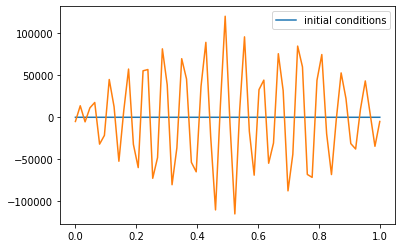

In [6]:
# start the solver

nx = 64
u = 1.0
C = 0.5

g = ftcs_advection(nx, u, C, init_cond=tophat)
fig = g.plot()

This result does not look very good. The solution should have look like the initial conditions after one period.

We know that our difference approximations should be more accurate at smaller $\Delta t$ and smaller $\Delta x$. Reducing $\Delta t$ is equivalent to picking a smaller $C$ number so we will do that and run the solver again.

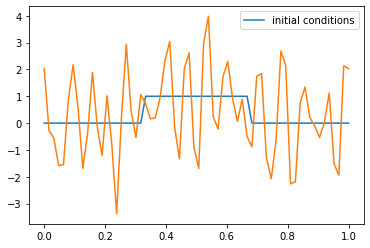

In [7]:
C = 0.1

g = ftcs_advection(nx, u, C, init_cond=tophat)
fig = g.plot()

This is still not the behavious we are expecting. Let's try evolving over less time

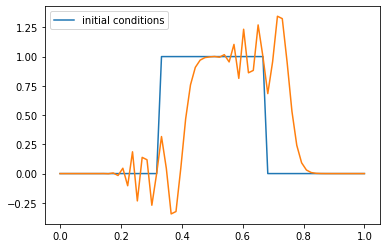

In [8]:
g = ftcs_advection(nx, u, C, init_cond=tophat, num_periods = 0.1)

fig = g.plot()

It looks better but something is happening at the discontinuities. Let's get better resolution

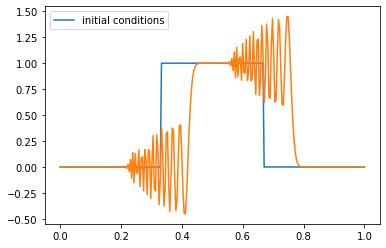

In [9]:
nx = 256

g = ftcs_advection(nx, u, C, init_cond=tophat, num_periods=0.1)
fig = g.plot()

This is better but we can see that there are still issues near the dicontinuities. Maybe a better scheme would produce a more stable result?

# Stability

The issue is that the FTCS method is unstable. There are different ways that we can analyze stability. We start with a $\underline{truncation\phantom{a} analysis}$

## Truncation Analysis

Start with the discrete form:

$$ a^{n+1}_{i} = a^{n}_{i} - \frac{C}{2} (a^{n}_{i+1} - a^{n}_{i-1})$$

and consider the Taylor expansion in space and time:

$$a^{n}_{i \pm 1} = a^{n}_{i} \pm a_{x} \Delta x + \frac{1}{2} a_{xx} \Delta x^{2} + \mathcal{O}(\Delta x^{3})  $$

$$a^{n \pm 1}_{i} = a^{n}_{i} + a_{t} \Delta t + \frac{1}{2} a_{tt} \Delta t^{2} + \mathcal{O}(\Delta t^{3}) $$

We can substitute the $a_{tt}$  time derivatives in the latter expansion with the analytic equation:

$$ a_{t} = -u a_{x}$$

$$ a_{tt} = -u \frac{\partial}{\partial t} \frac{\partial a}{\partial x} = u^{2} a_{xx} $$

Now substituting these into our original discrete equation:

$$a^{n}_{i} + a_{t} \Delta t + \frac{1}{2} u^{2} a_{xx} \Delta t^2 + \mathcal{O}(\Delta t^{3}) = a^{n}_{i} - \frac{C}{2} (2 a_{x} \Delta x) + \mathcal{O}(\Delta x^3) $$

which simplifies to:

$$ a_{t} + u a_{x} = -\frac{1}{2} u^2 a_{xx} \Delta t + \mathcal{O}(\Delta t^3) + \mathcal{O}(\Delta x^3) $$

The left side of this equation looks like our linear advection equation that we started but when we keep some of the terms from the Taylor expansion, we see that our discrete equation more properly represents an advection equation with a term proportional to $a_{xx}$ on the right hand side. 

This looks like a diffusion term. The action of diffusion is to take a peaked distribution and smear it out over time. But out diffusion term has a negative coefficient, so it is more of an anti-diffusion term, which is unphysical and there is no value of $\Delta t$ that makes the diffusion positive and therefore the analysis is unstable. 

## Upwinding

Let's try a different discretization. We can approximate the space derivative using a one-sided difference of either:

$$ (a_{x})_{i} \approx \frac{a_{i} - a_{i-1}}{\Delta x} + \mathcal{O}(\Delta x) $$

or 

$$ (a_{x})_{i} \approx \frac{a_{i+1} - a_{i}}{\Delta x} + \mathcal{O}(\Delta x) $$

We will choose the one that is an upwinded difference --  this means that we want to make use of the points from the direction that information is flowing. In our case, $u > 0$, so we want to use the point to the left of $i$ in approximating our derivative.

Chosing this difference makes us first-order accurate in space and time. Therefore, our difference equation is:

$$\frac{a^{n+1}_{i} - a^{n}_{i}}{\Delta t} = -u \frac{a^{n}_{i} - a^{n}_{i-1}}{\Delta x} $$

Now we will run this upwind method on our linear advection equation with the same tophat initial conditions and peridodic boundary conditions.

In [10]:
from re import T
def upwind_advection(nx, u, C, num_periods = 1.0, init_cond = None):

  # create the grid object to be passed
  g = FDGrid(nx)

  # time information
  dt = C * g.dx / u
  t = 0.0
  tmax = num_periods * (g.xmax - g.xmin) / u
  
  # initialize the data
  init_cond(g)

  g.ainit[:] = g.a[:]

  # evolution loop
  anew = g.scratch_array()

  while t < tmax:
    if t + dt > tmax:
      dt = tmax - t
      C = u * dt / g.dx

    # fill in the boundary conditions
    g.fill_BCs()

    for i in range(g.ilo, g.ihi+1):
      anew[i] = g.a[i] - C * (g.a[i] - g.a[i-1])

    # store the updated solution
    g.a[:] = anew[:]

    t += dt

  return g

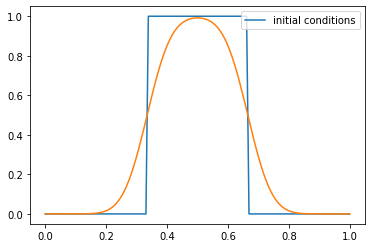

In [11]:
# run the new upwind solver

C = 0.5
u = 1.0
nx = 128

g = upwind_advection(nx, u, C, init_cond=tophat)
fig = g.plot()

This method looks much more stable near the discontinuities and also mathces the initial conditions better

# Convergence

In order to see whether our methods are working as designed, we need to be able to measure the convergence rate. With the ODE orbit problem, we had a single point (the current position of the Earth) at the end of our integration. Now we have $N$ points at the new time so we need to define a metric that allows us to quantify the error.

We will use a vector norm, $L_{2}$ for a set of discrete data $\phi_{i}$ as:

$$ ||\phi||_{2} = \left( \Delta x \sum^{N-1}_{i=0} \phi^{2}_{i} \right)^{1/2} $$

and then we can define an error as $e_{i} = a_{i} - a^{exact}(x_{i})$ for all points in our domain and compute the error $\epsilon$ as $||e||_{2}$.

Further, for our probelm, after one period, we know that the exact solution is just the initial conditions, so we can write:

$$ \epsilon = ||a^{final}_{i} - a^{initial}_{i}||_{2} = \left( \Delta x \sum^{N-1}_{i=0} (a^{final}_{i} - a^{initial}_{i})^2 \right)^{1/2} $$

One final note, it only makes sense to discuss convergence if the initial conditions also converge. For the tophat, there is a discontinuity, so as we increase and increase the resolution, we will never resolve the step. So the tophat is not a good set of initial conditions to assess convergence. We should use a smooth problem.

## Example

We will compute the $||L||_2$ norm of the error for our upwaind method. In order for it to make sense we must use smooth initial conditions as:

$$ a(x, t=0) = 1 + \frac{1}{2} \sin(2 \pi x) $$

Now vary the grid points and measure the error and estimate the rate of convergence.

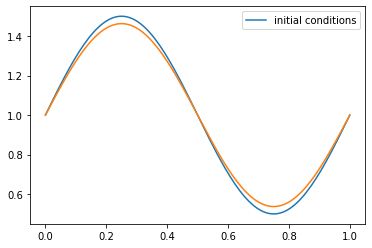

In [12]:
def sine(g):
  g.a[:] = 1.0 + 0.5 * np.sin(2.0 * np.pi * g.x)

g = upwind_advection(nx, u, C, init_cond=sine)
fig = g.plot()

In [13]:
# define the error function
def error(g):
  err = 0.0

  for i in range(g.ilo, g.ihi+1):
    err += (g.a[:] - g.ainit[:])**2

  err /= g.nx

  return np.sqrt(err)              

In [23]:
# run the solver and calculate the error
u = 1.0
C = 0.5

for nx in [32, 64, 128, 256, 512]:
  g = upwind_advection(nx, u, C, init_cond=sine)
  print(f"{nx:3d} {error(g)[-1]:7.4f}")

 32  1.1006
 64  1.0498
128  1.0247
256  1.0123
512  1.0061
